# **Part 2.1**


1.   Implementation of White Balance algorithms: **Gray World and White Patch**
2.   Implementation of **Unsharp Masking**
3. White balancing on resulting sharpened images



## White Balance algorithms: Gray World and White Patch
White Balance algorithms allow data scientist achieve more accurate color representation of the digital images.
As per definition: *white balance refers to the adjustment of colors in an image to ensure that white objects appear truly white, regardless of the lighting conditions under which the photo was taken.*

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
import pandas as pd

Below you can see initial images that were chosen for this assignment.

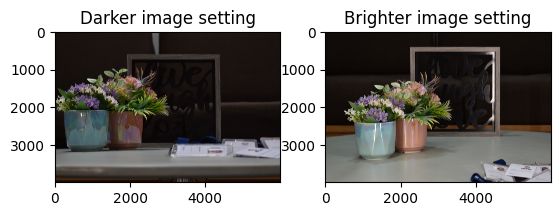

In [26]:
dark_image = imread('DSC_0021.JPG')
light_image = imread('DSC_0015.JPG')

#plotting both images for further work

images, axarr = plt.subplots(1,2)
axarr[0].imshow(dark_image)
axarr[0].set_title("Darker image setting")
axarr[1].imshow(light_image)
axarr[1].set_title("Brighter image setting")
plt.show()

### **Gray World Algorithm for color correction**
**Assumption:** On average, each photo contains of equal amounts of read, green and blue pixels
**Advantages:** Simple, effective and widely used
**Disadvantage:** May not work well in case of not balanced color distribution

In [27]:
def gray_world_algorithm(img):
  # for the gray world we need to scale each channel based on illumination
  # estimate and channel mean to normalize values of all three color channels
  # s = avg(avg_R, avg_G, avg_B)/avg_i, where i = {R, G, B}
  rgb = np.float32(img)
  red = rgb[:, :, 0]
  green = rgb[:, :, 1]
  blue = rgb[:, :, 2]

  #let's calculate illumination estimate avg
  avg_R = np.mean(red)
  avg_G = np.mean(green)
  avg_B = np.mean(blue)

  avg = np.divide(sum([avg_R, avg_G, avg_B]), 3)

  red_scalar_avg, green_scalar_avg, blue_scalar_avg = 0, 0, 0

  #let's scale all three colors
  for red_value in red:
    red_value = np.multiply(red_value, np.divide(avg, avg_R))
    red_scalar_avg += np.divide(avg, avg_R)

  for green_value in green:
    green_value = np.multiply(green_value, np.divide(avg, avg_G))
    green_scalar_avg += np.divide(avg, avg_G)

  for blue_value in blue:
    blue_value = np.multiply(blue_value, np.divide(avg, avg_B))
    blue_scalar_avg += np.divide(avg, avg_B)

  # building modified image
  gray_world_image = img
  gray_world_image[:, :, 0] = red
  gray_world_image[:, :, 1] = green
  gray_world_image[:, :, 2] = blue

  return gray_world_image, [np.divide(red_scalar_avg, len(red)),
                            np.divide(green_scalar_avg, len(green)),
                            np.divide(blue_scalar_avg, len(blue))]


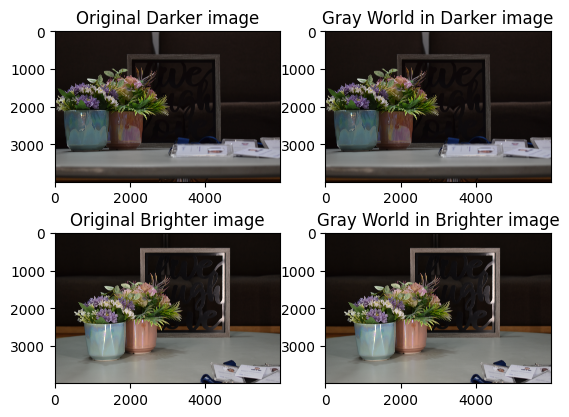

In [28]:
gray_world_dark_image, gray_world_dark_image_scalars = gray_world_algorithm(dark_image)
gray_world_light_image, gray_world_light_image_scalars = gray_world_algorithm(light_image)

#plotting original and modified images

images, axarr = plt.subplots(2,2)
axarr[0, 0].imshow(dark_image)
axarr[0, 0].set_title("Original Darker image")
axarr[0, 1].imshow(gray_world_dark_image)
axarr[0, 1].set_title("Gray World in Darker image")
axarr[1, 0].imshow(light_image)
axarr[1, 0].set_title("Original Brighter image")
axarr[1, 1].imshow(gray_world_light_image)
axarr[1, 1].set_title("Gray World in Brighter image")
plt.show()

In [29]:
print("Average scalar values for RGB in dark image: ", gray_world_dark_image_scalars)
print("Average scalar values for RGB in light image: ", gray_world_light_image_scalars)

Average scalar values for RGB in dark image:  [0.9256712969618014, 1.0071212697443754, 1.0790119037851287]
Average scalar values for RGB in light image:  [0.9334023915703314, 0.9922237850355413, 1.0859961937779732]


We can see that in the output, when comparing images before and after color normalization, both pictures appear to be the same. After validation, it became obvious that with the Gray World approach and color balance of selected images, value used for scaling would be ~1, resulting in images being almost the same. Which actually proves that in "real world scenario" to color correct this particular image we need to use different algorithm. White Patch, for instance.

### **White Patch Algorithm for color correction**
**Assumption:** White objects should have the same color intensity in all three color channels
**Advantages:** Simple and easy to implement
**Disadvantage:** Algorithm suffers when there is no or no easily identifiable white or neutral object in the picture

In [30]:
def white_patch_algorithm(img, percentile = 95):
  # We have to stretch each color band that way, so we are able to normalize colors using the one with the highest intensity
  # For this we will use intensity values of each color retrieved with the help of percentile values of each color channel
  # Which will help with avoiding 'white' pixels in order not to make resulting image overly white

  img = img.copy()

  red = img[:, :, 0]
  green = img[:, :, 1]
  blue = img[:, :, 2]

  # Calculation of percentiles for each band
  red_perc = np.percentile(red, percentile)
  green_perc = np.percentile(green, percentile)
  blue_perc = np.percentile(blue, percentile)

  # let's normalize all color bands based on these values
  img = img / [red_perc, green_perc, blue_perc]

  return img.clip(0,1)

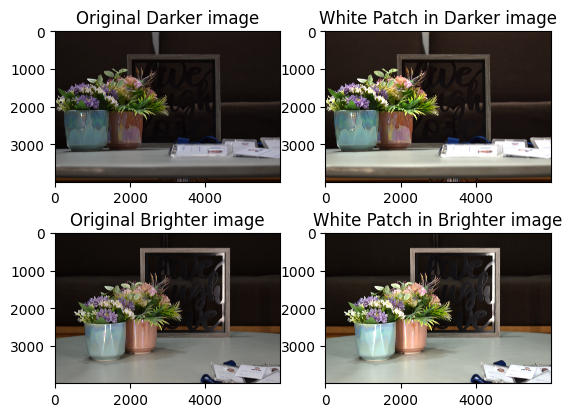

In [31]:
white_patch_dark_image = white_patch_algorithm(dark_image, 97)
white_patch_light_image = white_patch_algorithm(light_image, 98.5)

#plotting original and modified images

images, axarr = plt.subplots(2,2)
axarr[0, 0].imshow(dark_image)
axarr[0, 0].set_title("Original Darker image")
axarr[0, 1].imshow(white_patch_dark_image)
axarr[0, 1].set_title("White Patch in Darker image")
axarr[1, 0].imshow(light_image)
axarr[1, 0].set_title("Original Brighter image")
axarr[1, 1].imshow(white_patch_light_image)
axarr[1, 1].set_title("White Patch in Brighter image")
plt.show()

For this particular set of pictures we can see that "White Patch" algorithm works much better. It stretched all color bands in a way that gradually improved color quality, especially in the darker image set up. To have this freedom of color adjustment it was important to add percentile value, to be able to find the best for both images, which will be different having various near-white spots in second image that impact the final value stretch.